In [1]:
import numpy as np
import networkx as nx
import lib.node2vec.node2vec as n2v
import os, csv

In [2]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from src.constants import STORE_LOCATION
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from src.constants import STORE_LOCATION

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
%matplotlib notebook

In [4]:
def read_graph(input, weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(input, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not directed:
        G = G.to_undirected()

    return G

In [7]:
p, q = 0.25, 0.25

In [16]:
graph_loc = os.path.join(STORE_LOCATION, 'graphs/user-user.txt')

In [17]:
nx_G = read_graph(graph_loc)

In [25]:
G = n2v.Graph(nx_G, False, p, q)

In [26]:
G.preprocess_transition_probs()

In [27]:
walks = G.simulate_walks(10, 80)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [28]:
np.savez_compressed(os.path.join('data_temp/', 'user-user-walks.npz'), np.array(walks))

In [29]:
walks = [map(str, walk) for walk in walks]

In [31]:
w2v = Word2Vec(walks, size=80, window=8, min_count=0, sg=1, workers=8, iter=5)

In [32]:
w2v.save_word2vec_format(os.path.join('data_temp/', 'user-user-emb.emb'))

In [4]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [5]:
w2v = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'uu_p0.25-q0.25.emb'), binary=False)

## Clustering

In [ ]:
inertias = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True)
    kmeans.fit(w2v.syn0)
    inertias.append(kmeans.inertia_)

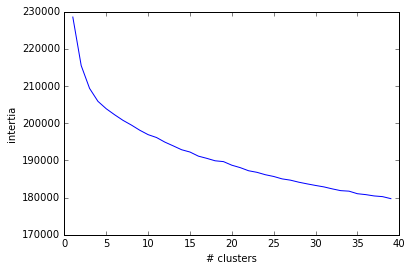

In [59]:
%matplotlib inline
plt.plot(range(1, 40), inertias)
plt.xlabel('# clusters')
plt.ylabel('intertia')

In [6]:
kmeans = KMeans(n_clusters=10, n_jobs=-1, precompute_distances=True)
kmeans.fit(w2v.syn0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

## PCA

In [7]:
pca = PCA(n_components=3)

Y_pca = pca.fit_transform(w2v.syn0)

<IPython.core.display.Javascript object>


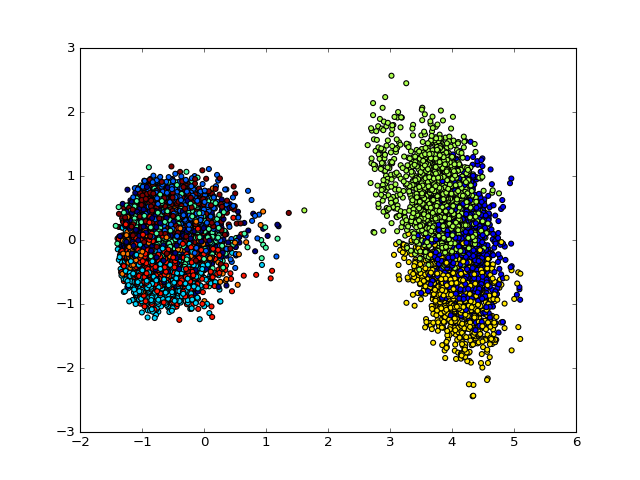

In [10]:
%matplotlib notebook
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=kmeans.labels_)

<IPython.core.display.Javascript object>


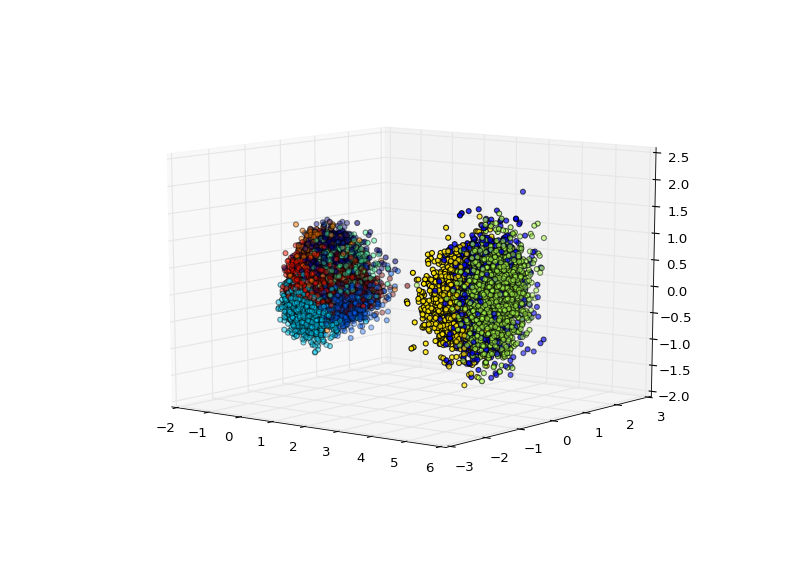

In [13]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_pca[:, 0], Y_pca[:, 1], Y_pca[:, 2], c=kmeans.labels_)

ax.view_init(90, 270)
plt.draw()